In [137]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product

In [2]:
filename = "IMOS_SOOP-BA_AE_20160412T031347Z_VLMJ_FV02_Investigator-EK60-18_END-20160414T043251Z_C-20210622T061448Z.nc"
ds = xr.open_dataset(filename)

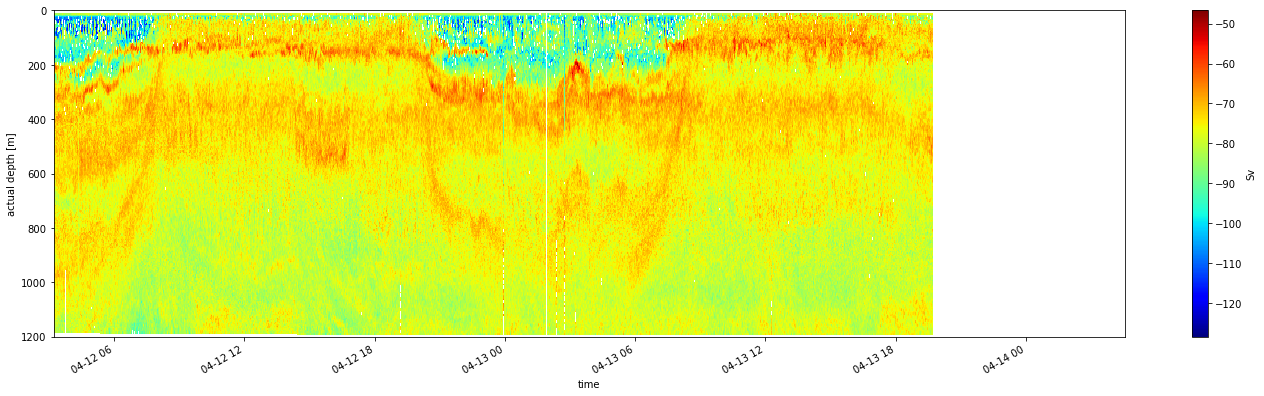

In [3]:
# plot sv data with 10log_10 scaling
fig = (10*np.log10(ds.Sv)).plot(x='TIME', size=6, aspect=4, cmap="jet")
# invert y axis so that depth increases downwards
plt.gca().invert_yaxis()

In [4]:
# rolling object
depthRoll = ds.Sv.rolling(DEPTH=10, min_periods=3)

In [154]:
def find_layer(xarr_col):
    '''
    find_layer: defines a boolean mask for one column of a x array data frame determining 
                if each pixel is a SSL as defined in Proud 2015. 
                Rolls window of length "above_window_size" from the start of the array, 
                and window of length "below_window_size" from the end of the array (executed
                by flipping xarr_col). An auxillary "window" dimension is created using 
                rolling.construct() with all values above/below each element of xarr_col 
                within the defined above/below window sizes.
                The mean of the above and below windows are taken along this dimension,
                excluding the element shared by both windows. This elements values is compared
                to these window means: the mask returns TRUE if the elements value is greater
                than both means and FALSE otherwise.
    Inputs: xarr_col (xarray.DataArray, 1 dimension) - one column of data (i.e. one ping)
            above_window_size (int) - number of elements above and including each pixel to 
                 calculate the mean of these pixels (excluding )
    '''
    
    n_val = len(xarr_col.data)
    
    def window_mean(xarr_col, min_per):
        '''
        window_mean: expands xarr_col vector into auxillary "window" dimension of size window_size
                   and take nanmean within the window
        '''
        window_matrix = xarr_col.rolling({xarr_col.dims[0]:n_val},min_periods=min_per).construct("window_dim")
         # flip the window so we can have rolling mean starting from numbers, not nan
        flipped_window = np.flip(window_matrix[1:-3,:-1], axis=1)
        # rolling means of values 
        mean_window = flipped_window.data.cumsum(axis=1)/range(1, len(flipped_window[0]) + 1)
        # create mask using means
        mean_mask = np.any([mean_window[x] < xarr_col.data[x] for x in range(len(flipped_window))], axis=1)
        return mean_mask
    
    above_mean = window_mean(xarr_col,n_val) # means for above windows
    flipped_xarr_col = xr.DataArray(np.flip(xarr_col.data), dims=(xarr_col.dims[0])) # flip for mean below windows
    below_mean = window_mean(flipped_xarr_col,n_val) # means for below windows
     # add in falses for top and bottom of columns - removed above due to too few values for averages (Proud wants at least 2)
    return np.concatenate(([False, False], above_mean & below_mean, [False, False]))

In [155]:
# Tests with 1-10
a = xr.DataArray(np.arange(10), dims=("dim1"))
find_layer(a)

In [157]:
# actual echogram data
n = 10 # number of columns to test
test_columns = xr.DataArray(ds.Sv,dims=("TIME","DEPTH"))[:10, :]

In [159]:
masked_columns = copy.deepcopy(test_columns) # find mask columns
temp = []
for t in range(len(masked_columns.data[:10, :])):
    temp.append(find_layer(ds.Sv.isel(TIME=t)))
masked_columns.data = temp

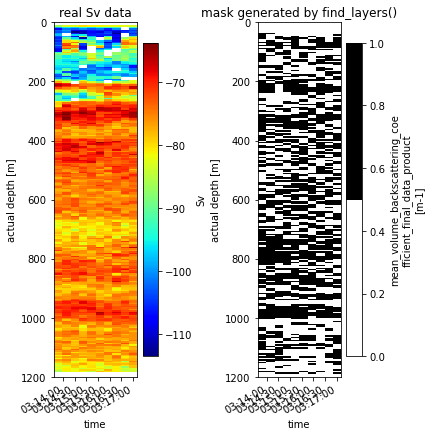

In [158]:
# Plotting
fig, axes = plt.subplots(1,2,figsize=(6,6))

# plot data with 10log_10 scaling
#cmap = mpl.colors.ListedColormap(['w', 'k'])
fig = (10*np.log10(test_columns)).plot(x='TIME', cmap="jet",ax=axes[0])
fig = (masked_columns).plot(x='TIME', cmap=cmap,ax=axes[1])

plt.tight_layout()

# invert y axis so that depth increases downwards
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# titles
axes[0].set_title("real Sv data");
axes[1].set_title("mask generated by find_layers()");